## Sea Ice Sonification


In [1]:
#from __future__ import division
import pandas as pd
import numpy as np
from pyknon.genmidi import Midi
from pyknon.music import NoteSeq, Note, Rest
import sys
#sys.path.append('gisstempRecon/')
from data_mapping import *
from IPython.display import Image
#plotting packages
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 5.0)
sns.set_style("darkgrid")
cmap = sns.cubehelix_palette(n_colors = 40, start = .5, rot = -.75, hue = 1)
sns.set_palette(cmap)


In [2]:
def sonify(x, octRange = 2,ntones = 11, baseOct = 3):
    #sonify the series
    octs,notes = map_to_range(x,octRange, ntones,baseOct)
    return NoteSeqWithNaN(notes, octs)

In [3]:
def annualVolume(vols, nyrs):
    #vols is an annual array of values that will be mapped to monthly volumes
    #map to the volume range 50:110. Midi range is 0:127
    vols = vols - np.nanmin(vols)
    newVols = vols/np.nanmax(vols)*60. + 50.
    monVols = np.ravel(np.ones([12,nyrs])*newVols, order = 'F')
    monVols[np.isnan(monVols)] = 0
    return monVols

        

In [4]:
from music21 import *
def playMidi(filename):
    mf = midi.MidiFile()
    mf.open(filename)
    mf.read()
    mf.close()
    s = midi.translate.midiFileToStream(mf)
    s.show('midi')

In [5]:
xlsFile = pd.ExcelFile('Sea_Ice_Index_Monthly_Data_by_Year_G02135_v2.1.xlsx' )
xlsFile.sheet_names

['NH-Extent', 'NH-Area', 'SH-Extent', 'SH-Area', 'Documentation']

In [6]:
#Arctic
NH = xlsFile.parse('NH-Extent')
nh_array = NH.iloc[1:,0:12].values.flatten() # continuous array of monthly values
nh_min = np.asarray(NH.iloc[1:,8]) # Sept
nh_max = np.asarray(NH.iloc[1:,2]) # March
nyrs = int(len(nh_array)/12)

#Antarctic
SH = xlsFile.parse('SH-Extent')
sh_array = SH.iloc[1:,0:12].values.flatten() # all months
sh_min = np.asarray(SH.iloc[1:, 2]) # March
sh_max = np.asarray(SH.iloc[1:, 8]) # September


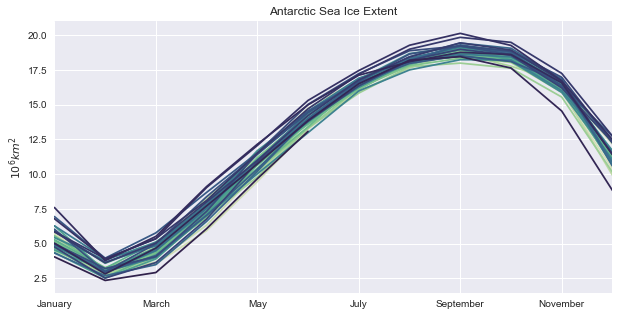

In [7]:
#plot Antarctic
sh0 = SH.iloc[1:, :12]
sh1 = SH.iloc[1:,1:12] # Feb : Dec
sh2 = SH.iloc[1:,0:2] #January, February
sh = pd.concat([sh1,sh2], axis = 1)
sh0.T.plot(legend = False)
plt.title('Antarctic Sea Ice Extent')
plt.ylabel('$10^6 km ^2$')
plt.show()

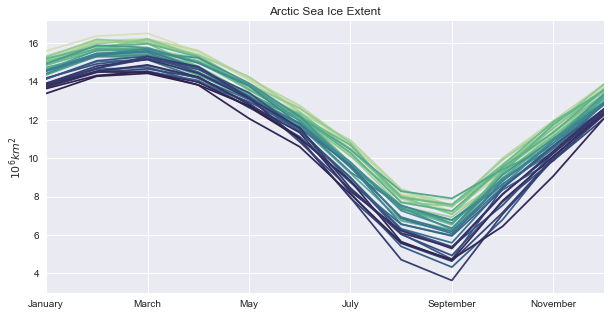

In [8]:
#Plot Arctic
nh0 = NH.iloc[1:, :12]
nh1 = NH.iloc[1:,8:12]
nh2 = NH.iloc[1:, :9]
nh = pd.concat([nh1, nh2], axis = 1)
nh0.T.plot(legend = False)
plt.title("Arctic Sea Ice Extent")
plt.ylabel('$10^6 km ^2$')
plt.show()

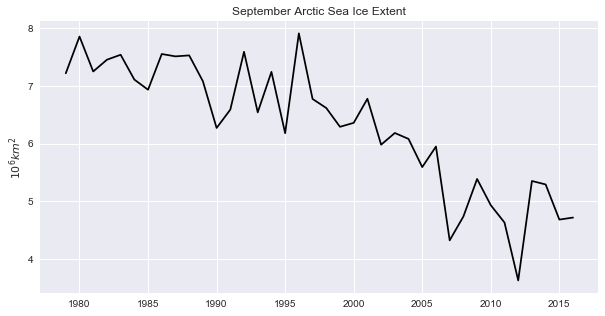

In [9]:
plt.plot(NH.iloc[1:,8], color = 'k')
plt.title('September Arctic Sea Ice Extent')
plt.ylabel('$10^6 km ^2$')
plt.show()

In [10]:
#Create the note Sequence for monthly values, mapping ice extent to pitch
octaves, tones = mapMatrix_to_range([nh_array, sh_array],6,7,3)
nh_octave, sh_octave = octaves
nh_notes, sh_notes = tones
#shift to a harmonic minor scale
nh_notes = convert_scale(nh_notes, scale = 'harm_minor')
sh_notes = convert_scale(sh_notes, scale = 'harm_minor')
#set sound level for each hear
nh_volumes = annualVolume(nh_min, nyrs)
sh_volumes = annualVolume(sh_min, nyrs)
#construc the note sequence. Missing data is a musical rest. 
nh_noteSeq = NoteSeqWithNaN(nh_notes, nh_octave, 1/16, nh_volumes)# volume each year modified by min. ice extent
sh_noteSeq = NoteSeqWithNaN(sh_notes, sh_octave, 1/16, sh_volumes)


In [11]:
#create intervals from the yearly extrema for each hemisphere
nh_ext_oct, nh_ext_notes = mapMatrix_to_range([nh_max, nh_min], 5,7,3)
nh_max_oct, nh_min_oct = nh_ext_oct
nh_max_notes, nh_min_notes = nh_ext_notes
nh_max_notes = convert_scale(nh_max_notes, scale = 'harm_minor')
nh_min_notes = convert_scale(nh_min_notes, scale = 'harm_minor')
nh_max_noteSeq = NoteSeqWithNaN(nh_max_notes, nh_max_oct, 1/16)
nh_min_noteSeq = NoteSeqWithNaN(nh_min_notes, nh_min_oct, 1/16)

In [12]:
NH_min = sonify(nh_min) #Sept
NH_max = sonify(nh_max) # March
SH_min = sonify(sh_min) # February
SH_max = sonify(sh_max) # Sept
SH_november = sonify(np.asarray(SH.iloc[1:,10]))


In [13]:
foo = Midi(tempo = 180, number_tracks = 1)
#NH_min, NH_max, SH_min, SH_max, SH_november
foo.seq_notes(NH_min, track = 0, time = 0) # swap out any of the above to listen
foo.write("foo.midi")
playMidi('foo.midi')

In [14]:
# Play the max/min for each year as an interval
annualIceRange = Midi(number_tracks = 2)
annualIceRange.seq_notes(nh_max_noteSeq, track = 0)
annualIceRange.seq_notes(nh_min_noteSeq, track = 1)
annualIceRange.write('NH_iceExtent_MinMax.midi')

playMidi('NH_iceExtent_MinMax.midi')

In [15]:
# write NH and SH monthly vals as 2 concurrent tracks
# Summer minimum modifies the sound volume. 
iceSound = Midi(tempo = 180, number_tracks = 2)
iceSound.seq_notes(nh_noteSeq, track = 0)
iceSound.seq_notes(sh_noteSeq, track = 1)
iceSound.write('iceExtentMonthly.midi')

playMidi('iceExtentMonthly.midi') #Both NH and SH

In [16]:
#write each hemisphere as individual tracks
iceSound_NH  = Midi(tempo = 120)
iceSound_NH.seq_notes(nh_noteSeq)
iceSound_NH.write('NH_iceExtentMonthly.midi')

iceSound_SH = Midi(tempo = 180)
iceSound_SH.seq_notes(sh_noteSeq)
iceSound_SH.write('SH_iceExtentMonthly.midi')

playMidi('NH_iceExtentMonthly.midi') 

In [17]:
s = converter.parse("NH_iceExtentMonthly.midi")
s.keySignature = key.Key('C', 'minor')
s.keySignature.sharps
s.write('lily.pdf')
#s.show()


LilyTranslateException: Cannot find a copy of Lilypond installed on your system. Please be sure it is installed. And that your environment.UserSettings()['lilypondPath'] is set to find it.

### Subset just the first year to create a short animation

In [ ]:
nh1979 = NH.iloc[1, :12]
nh1979.T.plot()
plt.show()

In [ ]:
iceAnnual_NH  = Midi(tempo = 70)
iceAnnual_NH.seq_notes(nh_noteSeq[:13])
iceAnnual_NH.write('NH_iceExtent_1year.midi')
playMidi('NH_iceExtent_1year.midi')

In [ ]:
import matplotlib.ticker as ticker
from matplotlib import animation, rc
from IPython.display import HTML

In [ ]:
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()
ax.set_ylim(( min(nh1979)-1, max(nh1979)+1))
ax.set_xlim((0, 11))
ax.set_facecolor('black')
ax.grid(False)
line, = ax.plot([], [], lw=1, color = 'steelblue')
dot, = ax.plot([], [], 'bo', ms = 5, color = 'steelblue')
xlabels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aaug', 'Sept', 'Oct', 'Nov', 'Dec']
plt.xlabel('1979')
plt.ylabel('million square kilometers')
plt.xticks(np.arange(1,13), xlabels, rotation = -30)
months = np.arange(1,13)

In [ ]:
# initialization function: plot the background of each frame
def init():
    #line.set_data([], [])
    dot.set_data([], [])
    return (line,)

In [ ]:
# animation function. This is called sequentially
def animate(i):
    global nh1979, months
    line.set_data(months[:i], nh1979[:i])
    dot.set_data(months[:i], nh1979[:i])
    dot.set_markersize(5)
    
    return (line,dot)

In [ ]:
# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,frames=12, interval=500, blit=True)

In [ ]:
HTML(anim.to_html5_video())


In [ ]:
anim.save('temp.mp4', fps=3, extra_args=['-vcodec', 'libx264',
                                          '-pix_fmt', 'yuv420p',
                                          # Trying to mux in audio here
                                          '-i', 'ArcticSeaIceExtent_12months.mp3', 
                                          '-acodec', 'copy'
                                         ])